In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from PIL import Image

In [2]:
#this works as long as it is inside code/
train_path = os.getcwd()[:-4] + "archive/train/"
test_path = os.getcwd()[:-4] + "archive/test/"

classes = os.listdir(train_path)

images = []
labels = []

for class_ in classes:
    full_path = train_path + str(class_) + "/"
    for file in os.listdir(full_path):
        img = Image.open(full_path + file)

        #needs to resize
        img = img.resize((30, 30))

        #Convert image to grayscale
        img = img.convert('L')
        
        #Convert image to numpy array (Feature Extraction)
        img = np.array(img).flatten()
        img.reshape(img.shape[0], 1)

        #Append image to list
        images.append(img)

        #Append label to list
        labels.append(np.uint8(class_))
        


X = np.array(images)
print("X:", type(X[0][0]))
y = np.array(labels)
y = y.reshape(y.shape[0], 1)
print("y:", type(y[0][0]))

print(X.shape, y.shape)


X: <class 'numpy.uint8'>
y: <class 'numpy.uint8'>
(39209, 900) (39209, 1)


In [3]:
# Normalize features
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean= np.mean(X, axis=0)
    std= np.std(X, axis=0)
    
    X_norm = (X - mean) / std
    
    return X_norm , mean , std

In [4]:
# Normalize X (feature scaling)
X, mean, std = featureNormalization(X)

In [22]:
#Split data without sklearn
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    if test_size > 1 or test_size < 0:
        raise ValueError("test_size must be smaller than 1")
    if test_size == 1:
        test_images = []
        test_labels = []

        for file in os.listdir(test_path):
            #Ignore csv file
            if file.endswith(".csv"):
                continue
            
            img = Image.open(test_path + file)

            #needs to resize
            img = img.resize((30, 30))

            #Convert image to grayscale
            img = img.convert('L')
            
            #Convert image to numpy array (Feature Extraction)
            img = np.array(img).flatten()
            img.reshape(img.shape[0], 1)

            #Append image to list
            test_images.append(img)

            #Append label to list
            test_labels.append(np.uint8(class_))

        return X, np.array(test_images), y, np.array(test_labels)
    
    shuffled_indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return np.array(X[train_indices]), np.array(X[test_indices]), np.array(y[train_indices]), np.array(y[test_indices])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=42)
y_test = y_test.reshape(y_test.shape[0], 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X.shape)


(39209, 900) (0, 900) (39209, 1) (0, 1)
(39209, 900)


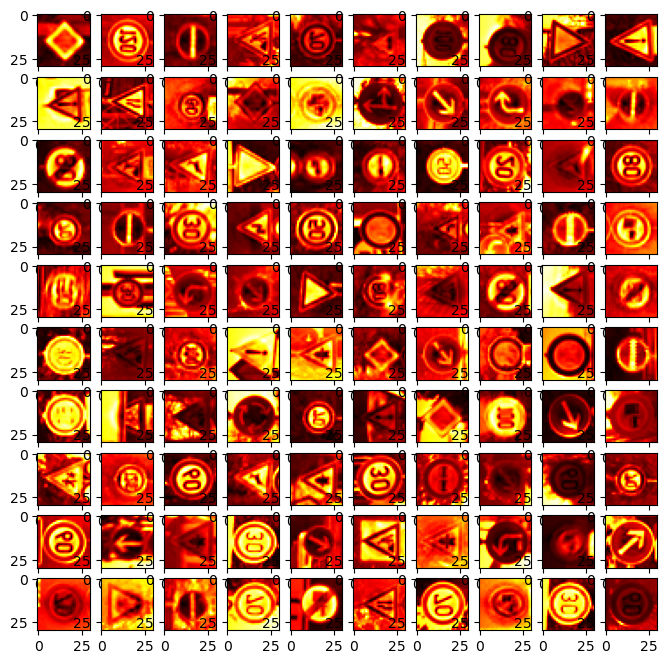

In [7]:
#Test if images were loaded correctly
fig, axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,X.shape[0]),:].reshape(30,30,order="F"), cmap="hot") 

# Cost Function

Regularized cost function for logistic regression:

$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

Cost gradients:

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$ for $j\geq 1$

In [8]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    gz=1/(1+np.exp(-z))
    
    return gz

In [9]:
# Regularized cost function and gradient
def costFunctionReg(theta, X, y, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m=len(y)
        
    #vector of the model predictions for all training examples      
    z = np.dot(X,theta)
    h = sigmoid(z)

    eps = 1e-15
    error = (-y * np.log(h + eps)) - ((1 - y) * np.log(1 - h + eps))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all


In [10]:
# Gradient descent function
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(theta,X,y,Lambda)
        
        #update theta
        theta = theta - (alpha * grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [11]:
# One vs all function
def oneVsAll(X, y, initial_theta, alpha, num_iters, Lambda, classes):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    classes -all possible classes in the dataset
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m=len(y)
    
    #number of features
    n= X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)),X,axis=1)
    
    for i in classes:
        print('training classes left:', len(classes) - classes.index(i))
        i = np.uint8(i)
        theta , J_history = gradientDescent(X,np.where(y==i,1,0),initial_theta,alpha,num_iters,Lambda)
        
        # sdd the vector of optimized parameters theta of classifier i
        all_theta.extend(theta)
                
        # add the cost function history of classifier i
        all_J.extend(J_history)
    
    print('Training completed!')
        
    return np.array(all_theta).reshape(len(classes),n+1), all_J

In [12]:
lr=[0.01, 0.1, 0.5, 1]
initial_theta = np.zeros((X_train.shape[1]+1,1))
X_alpha = np.append(np.ones((X_train.shape[0],1)),X_train,axis=1)
for i in lr:
    theta , J_history = gradientDescent(X_alpha, y_train, initial_theta, i, 400, 0.1)
    plt.plot([j for j in range(0, len(J_history))], J_history)

plt.xlabel('Iteration')
plt.ylabel('J(theta)')
plt.legend(lr)
plt.show()

ZeroDivisionError: division by zero

In [ ]:
#Inicialize vector theta =0
initial_theta = np.zeros((X_train.shape[1]+1,1))


#Optimization hyper-parameters 
alpha=0.1 #learning rate
num_iters=300
Lambda=0.1

all_theta, all_J = oneVsAll(X_train, y_train, initial_theta, alpha, num_iters, Lambda, classes)

In [ ]:
plt.plot(all_J)  #All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

print(all_theta.shape)

In [ ]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m=X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m,1)), X, axis=1)
    
    predictions = np.dot (X, all_theta.T)

    #np.argmax returns indices of the max element of the array in a particular axis.
    return np.argmax(predictions,axis=1)

In [ ]:
pred = predictOneVsAll(all_theta, X_test)

pred= pred.reshape(pred.shape[0], 1)

# Create a dictionary that maps indices to class labels
index_to_label = {i: np.int8(label) for i, label in enumerate(classes)}

# Define a function to map indices to class labels
def map_index_to_label(row):
    return np.vectorize(index_to_label.__getitem__)(row)

# Apply the function to each row of the pred array
pred = np.apply_along_axis(map_index_to_label, axis=1, arr=pred)


print("Training Set Accuracy:",sum(pred==y_test)[0]/len(y_test)*100,"%")

In [ ]:
# Visualize the theta for each class
for i in range(0, len(all_theta)):
        plt.imshow(all_theta[i][1:].reshape((30,30)), cmap='hot')
        plt.title('Generated Theta for class %d' %index_to_label[i])
        plt.show()
